<a name="top"></a><a id="top">
# [TFRecord and tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord)

0. [Setup](#setup)
1. [Introduction](#1.1)
2. [tf.train.Example](#2.0)
    * 2.1 [Data types for tf.train.Example](#2.1)
    * 2.2 [Creating a tf.train.Example message (w/o tf.data)](#2.2)
        - 2.2.1 [Creating a single Example message](#2.2.1)
        - 2.2.2 [Decoding a single Example message](#2.2.2)
        - 2.2.3 [Creating multiple Example messages](#2.2.3)
        - 2.2.4 [Decoding multiple Example messages](#2.2.4)
    * 2.3 [Operations on Examples: TFRecord saving, loading, reading](#2.3)
        - 2.3.1 [Saving a single record](#2.3.1)
        - 2.3.2 [Saving multiple records](#2.3.2)
        - 2.3.3 [Loading and reading a single record](#2.3.3)
        - 2.3.4 [Loading and reading multiple records](#2.3.4)
3. [TFRecord format details](#3.0)
4. [TFRecord files using tf.data](#4.0)
    * 4.1 [Writing a TFRecord file](#4.1)
        - 4.1.1 [tf.data.from_tensor_slices applied to an array](#4.1.1)
        - 4.1.2 [tf.data.from_tensor_slices applied to a tuple of arrays](#4.1.2)
        - 4.1.3 [Using tf.data.Dataset.map on a Dataset](#4.1.3)
            * 4.1.3.1 [Using tf.data.Dataset.map with tf.py_function](#4.1.3.1)
            * 4.1.3.2 [Create and save TFRecord (using tf.data.Dataset.map with tf.data.Dataset.from_generator)](#4.1.3.2)
            * 4.1.3.3 [Loading TFRecord files created via tf.data.Dataset.from_generator](#4.1.3.3)
    * 4.2 [Reading a TFRecord file](#4.2)
5. [TFRecord files in Python](#5.0)
    * 5.1 [Writing a TFRecord file](#5.1)
    * 5.2 [Reading a TFRecord file](#5.2)
6. [Walkthrough: Reading and writing image data](#6.0)
    * 6.1 [Fetch the images](#6.1)
    * 6.2 [Write the TFRecord file](#6.2)
    * 6.3 [Read the TFRecord file](#6.3)

---
<a id="setup"></a><a name="setup"></a>
# 0. Setup
<a href="#top">[back to top]</a>

In [1]:
%%time
import glob
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint as pp
import tensorflow as tf

# To make this notebook's output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

def HR():
    print("-"*40)
    
#print("Libraries loaded..")

CPU times: user 6.33 s, sys: 1.34 s, total: 7.67 s
Wall time: 19.9 s


---
<a id="1.1"></a><a name="1.1"></a>
# 1. Introduction
<a href="#top">[back to top]</a>

Conceptually, we want to explore four-interrelated APIs and the respective functionality provided.

1. **TFRecord** is a simple format for storing a sequence of binary records.

2. **[Protocol Buffers](https://developers.google.com/protocol-buffers/?hl=en)** (or *protobufs*), are what TensorFlow's file formats are based on. Protobufs are a cross-platform, cross-language library for efficient serialization of structured data. Protocol messages are defined by `.proto` files, which are often the easiest way to understand a message type. We define data structures in text files, and the [protobuf tools](https://chromium.googlesource.com/external/github.com/tensorflow/tensorflow/+/r0.10/tensorflow/g3doc/how_tos/tool_developers/index.md) use those to generate classes in Python (and other languages) that can load, save, and access data. 

3. **`tf.train.Example`** protobuf is a flexible message type that represents a `{"string": value}` mapping. It is designed for use with TensorFlow and is used throughout the higher-level APIs such as [TFX](https://www.tensorflow.org/tfx/). An Example is a standard protobuf-message that stores data for training and inference. `tf.train.Example` contains a key-value store `Example.features` where each key (string) maps to a `tf.train.Feature` message which contains a fixed-type list. This flexible and compact format allows the storage of large amounts of typed data, but requires that the data shape and use be determined by the configuration files and parsers that are used to read and write this format. A `tf.train.Example` proto is a representation of the following python type:

```
Dict[str,
     Union[List[bytes],
           List[int64],
           List[float]]]
```
    
4. **`tf.data API`** provides rich functionality for dataset manipulation, to enable descriptive and efficient input pipelines.

In summary, think of **TFRecord** as providing a high-performance binary storage format, **Protocol buffers** as the underlying mechanism for serializing structured data, **tf.train.Example** as providing a typed data-structure for storing Protocol buffers for training and inference, and **tf.data** as enabling rich functionality for dataset manipulation.

---
In terms of workflow, this notebook demonstrates:

* How to create, parse, and use `tf.train.Example` messages.
* How to serialize, write, and read `tf.train.Example` messages to and from `.tfrecord` files.

Note 1: While useful, these structures are optional. There is no need to convert existing code to use TFRecords, unless you are [using tf.data](https://www.tensorflow.org/guide/data) and reading data is still the bottleneck to training. You can refer to [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) for dataset performance tips.

Note 2: In general, you should shard your data across multiple files so that you can parallelize I/O (within a single host or across multiple hosts). The rule of thumb is to *have at least 10 times as many files as there will be hosts reading data*. Also, each file should be large enough (at least 10 MB+, ideally 100 MB+) so that you can benefit from I/O prefetching. For example, say you have `X` GB of data and you plan to train on up to `N` hosts. Ideally, you should shard the data to ~ `10*N` files, as long as ~ `X/(10*N)` is 10 MB+ (ideally 100 MB+). If it is less than that, you might need to create fewer shards to balance parallelism vs. I/O prefetching benefits.

---
<a id='2.0'></a><a name="2.0"></a>
# 2. tf.train.Example
<a href="#top">[back to top]</a>

<a id='2.1'></a><a name="2.1"></a>
## 2.1 Data types for tf.train.Example
<a href="#top">[back to top]</a>

Fundamentally, a `tf.train.Example` is a `{"string": tf.train.Feature}` mapping.

The `tf.train.Feature` message type can accept one of the following three types ([See the .proto file for reference](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto)). Most other generic types can be coerced into one of these List-types:

1. `tf.train.BytesList` (the following types can be coerced)
    - `string`
    - `byte`
2. `tf.train.FloatList` (the following types can be coerced)
    - `float` (`float32`)
    - `double` (`float64`)
3. `tf.train.Int64List` (the following types can be coerced)
    - `bool`
    - `enum`
    - `int32`
    - `uint32`
    - `int64`
    - `uint64`
  
In order to convert a standard TensorFlow type to a `tf.train.Example`-compatible `tf.train.Feature`, you can use the shortcut functions below. 

Note: each function takes a scalar input value and returns a `tf.train.Feature` containing one of the three list types:

In [2]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    # To avoid this warning, may need to cast boolean to int, via `int(value)`:
    # DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be 
    # interpreted as an index
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[int(value)]))

* **Note:** To stay simple, this example only uses scalar inputs. The simplest way to handle non-scalar features is to use `tf.io.serialize_tensor` to convert tensors to binary-strings. Strings are scalars in TensorFlow. Use `tf.io.parse_tensor` to convert the binary-string back to a tensor.

Below are some examples of how these functions work. Note the varying input types and the standardized output types. If the input type for a function does not match one of the coercible types stated above, the function will raise an exception. For example, `_int64_feature(1.0)` will error out because `1.0` is a float—therefore, it should be used with the `_float_feature` function instead:

In [3]:
print("Note: all of the below proto messages share this type:")
print(type(_bytes_feature(b'test_string')))
HR()

print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

Note: all of the below proto messages share this type:
<class 'tensorflow.core.example.feature_pb2.Feature'>
----------------------------------------
bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



2022-07-20 22:52:29.651780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


All proto messages can be serialized to a binary-string using the `.SerializeToString` method:

In [4]:
feature = _float_feature(np.exp(1))

print(type(feature))

# Serializes the message to a string, only for initialized messages.
feature.SerializeToString()

<class 'tensorflow.core.example.feature_pb2.Feature'>


b'\x12\x06\n\x04T\xf8-@'

<a id='2.2'></a><a name="2.2"></a>
## 2.2 Creating a tf.train.Example message (w/o tf.data)
<a href="#top">[back to top]</a>

This is the procedure for creating a `tf.train.Example` message from a single observation, for existing data (or any other dataset location).

1. Within each observation, each value needs to be converted to a `tf.train.Feature` containing one of the 3 compatible types, using one of the functions above.

2. Create a map (dictionary) from the feature name string to the encoded feature value produced in #1.

3. The map produced in step 2 is converted to a [`Features` message](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto#L85).

---

In this notebook, you will create a dataset using NumPy.

This dataset will have 4 features:

1. Boolean feature, `False` or `True` with equal probability
2. Integer feature uniformly randomly chosen from `[0, 5]`
3. String feature generated from a string table by using the integer feature as an index
4. Float feature from a standard normal distribution

Create a sample of 10,000 i.i.d observations from each of the above distributions:

In [5]:
# The number of observations in the dataset.
n_observations = int(10_000)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)
print(repr(feature0.dtype))
print(feature0[:5])
HR()

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)
print(repr(feature1.dtype))
print(feature1[:5])
HR()

# String feature.
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]
print(repr(strings.dtype))
print(repr(feature2.dtype))
print(feature2[:5])
# dtype('S7'): 'S7' means the object is a string and it contains 7 bytes. 
# Confirm via the 'itemsize' attribute.
print(feature2.itemsize)

HR()

# Float feature, from a standard normal distribution.
feature3 = np.random.randn(n_observations)
print(repr(feature3.dtype))
print(feature3[:5])

dtype('bool')
[False  True False False False]
----------------------------------------
dtype('int64')
[2 2 3 2 4]
----------------------------------------
dtype('S7')
dtype('S7')
[b'chicken' b'chicken' b'horse' b'chicken' b'goat']
7
----------------------------------------
dtype('float64')
[ 0.14140815  0.16677411 -0.84976487  0.70329666 -0.27729789]


---
Each of these features can be coerced into a `tf.train.Example`-compatible type using one of these user-defined functions:

* `_bytes_feature`
* `_float_feature` 
* `_int64_feature` 

We then wrap the resulting encoded-features in a `tf.train.Example` message.

In [6]:
def serialize_example(feature0, feature1, feature2, feature3, debug=False):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """

    # Create a Example datatype via a dictionary mapping the feature name 
    # to the tf.train.Example data type.
    record_bytes = (
        tf.train.Example(features=tf.train.Features(
            feature={
            'feature0': _int64_feature(feature0),
            'feature1': _int64_feature(feature1),
            'feature2': _bytes_feature(feature2),
            'feature3': _float_feature(feature3),
            }))
        # .SerializeToString()
    )
    
    if debug==True:
        print("INSIDE SERIALIZE_EXAMPLE")
        print(record_bytes)
        print(type(record_bytes))
        HR()
        
    # Serialize the Example, so we can pass a `bytes` or 
    # `bytearray` transformation to tf.io.TFRecordWriter.
    # SerializeToString is a protobuf method
    record_bytes_serialized = record_bytes.SerializeToString()
    
    if debug:
        print("INSIDE SERIALIZE_EXAMPLE")
        print(record_bytes_serialized)
        print(type(record_bytes_serialized))
        HR()

    return record_bytes_serialized

In [7]:
# Variation: Automatically detect value-type and define feature
def serialize_example_auto(*input, debug=False):
    features = dict()
    
    # Passing in values via variable length *args
    for i, value in enumerate(input):
        feature_name = f"feature_{i}"
    
        if isinstance(value, int):
            features[feature_name] = _int64_feature(value)
        elif isinstance(value, float):
            features[feature_name] = _float_feature(value)
        elif isinstance(value, bytes):
            features[feature_name] = _bytes_feature(value)
        else:
            raise ValueError(f"Value for {value} is not a recognized type: {str(value)}: {str(type(value))}")
    
    example = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString() 

    return example

---
For example, suppose you have a single observation from the dataset, 

`[False, 4, bytes('goat'), 0.9876]`

You can create and print the `tf.train.Example` message for this observation using `create_message()`. 

Each single observation will be written as a `Features` message as per the above. 

Note that the `tf.train.Example` [message](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/example.proto#L88) is just a wrapper around the `Features` message:

<a id="2.2.1"></a><a name="2.2.1"></a>
### 2.2.1 Creating a single Example message
<a href="#top">[back to top]</a>

In [8]:
# Example observation, created manually
serialized_example_single = serialize_example(
    False, 
    111, 
    b'goat_single', 
    0.1111, 
    debug=True
)

print(type(serialized_example_single))
HR()

print(serialized_example_single)

INSIDE SERIALIZE_EXAMPLE
features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 111
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat_single"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.11110000312328339
      }
    }
  }
}

<class 'tensorflow.core.example.example_pb2.Example'>
----------------------------------------
INSIDE SERIALIZE_EXAMPLE
b'\nY\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01o\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04f\x88\xe3=\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x1b\n\x08feature2\x12\x0f\n\r\n\x0bgoat_single'
<class 'bytes'>
----------------------------------------
<class 'bytes'>
----------------------------------------
b'\nY\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01o\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04f\x88\xe3=\n\x11

In [9]:
# Example observation, created automatically
serialized_example_auto = serialize_example_auto(
    True, 
    999, 
    b'goat_single_auto', 
    0.1234, 
    debug=True
)

print(serialized_example_auto)

b'\nc\n\x13\n\tfeature_1\x12\x06\x1a\x04\n\x02\xe7\x07\n\x15\n\tfeature_3\x12\x08\x12\x06\n\x04$\xb9\xfc=\n\x12\n\tfeature_0\x12\x05\x1a\x03\n\x01\x01\n!\n\tfeature_2\x12\x14\n\x12\n\x10goat_single_auto'


<a id="2.2.2"></a><a name="2.2.2"></a>
### 2.2.2 Decoding a single Example message
<a href="#top">[back to top]</a>

To decode a single message, use `tf.train.Example.FromString`.

In [10]:
# Decode manually created message
example_proto = tf.train.Example.FromString(serialized_example_single)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 111
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat_single"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.11110000312328339
      }
    }
  }
}

In [11]:
# Decode automatically created message
example_proto_auto = tf.train.Example.FromString(serialized_example_auto)
example_proto_auto

features {
  feature {
    key: "feature_0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature_1"
    value {
      int64_list {
        value: 999
      }
    }
  }
  feature {
    key: "feature_2"
    value {
      bytes_list {
        value: "goat_single_auto"
      }
    }
  }
  feature {
    key: "feature_3"
    value {
      float_list {
        value: 0.1234000027179718
      }
    }
  }
}

<a id="2.2.3"></a><a name="2.2.3"></a>
### 2.2.3 Creating multiple Example messages
<a href="#top">[back to top]</a>

In [12]:
# Create multiple Features message
serialized_example_multiple = [
    serialize_example(False, 1, b'goat1', 0.9876, debug=False),
    serialize_example(True, 2, b'goat2', 1.3, debug=False),            
    serialize_example(False, 3, b'goat3', 0.02, debug=False),
    serialize_example(False, 4, b'goat4', 0.9876, debug=False),
    serialize_example(True, 5, b'goat5', 1.3, debug=False),            
    serialize_example(False, 6, b'goat6', 0.02, debug=False),
    serialize_example(False, 7, b'goat7', 0.9876, debug=False),
    serialize_example(True, 8, b'goat8', 1.3, debug=False),            
    serialize_example(False, 9, b'goat9', 0.02, debug=False),
]

pp.pprint(serialized_example_multiple)

[b'\nS\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat1\n\x11\n\x08feature'
 b'0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n'
 b'\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?',
 b'\nS\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04ff\xa6?\n\x11\n\x08feature0'
 b'\x12\x05\x1a\x03\n\x01\x01\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat2\n\x11'
 b'\n\x08feature1\x12\x05\x1a\x03\n\x01\x02',
 b'\nS\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat3\n\x11\n\x08feature'
 b'1\x12\x05\x1a\x03\n\x01\x03\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n'
 b'\x14\n\x08feature3\x12\x08\x12\x06\n\x04\n\xd7\xa3<',
 b'\nS\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat4\n\x11\n\x08feature'
 b'1\x12\x05\x1a\x03\n\x01\x04\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n'
 b'\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?',
 b'\nS\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat5\n\x11\n\x08feature'
 b'1\x12\x05\x1a\x03\n\x01\x05\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n'
 b'\x14\n\x08feature3\x12\x08\x12\

In [13]:
# Create multiple Features message
serialized_example_multiple_auto = [
    serialize_example_auto(False, 1, b'goat1', 0.9876, debug=False),
    serialize_example_auto(True, 2, b'goat2', 1.3, debug=False),            
    serialize_example_auto(False, 3, b'goat3', 0.02, debug=False),
    serialize_example_auto(False, 4, b'goat4', 0.9876, debug=False),
    serialize_example_auto(True, 5, b'goat5', 1.3, debug=False),            
    serialize_example_auto(False, 6, b'goat6', 0.02, debug=False),
    serialize_example_auto(False, 7, b'goat7', 0.9876, debug=False),
    serialize_example_auto(True, 8, b'goat8', 1.3, debug=False),            
    serialize_example_auto(False, 9, b'goat9', 0.02, debug=False),
]

pp.pprint(serialized_example_multiple_auto)

[b'\nW\n\x12\n\tfeature_1\x12\x05\x1a\x03\n\x01\x01\n\x15\n\tfeature_3\x12'
 b'\x08\x12\x06\n\x04[\xd3|?\n\x12\n\tfeature_0\x12\x05\x1a\x03\n\x01'
 b'\x00\n\x16\n\tfeature_2\x12\t\n\x07\n\x05goat1',
 b'\nW\n\x15\n\tfeature_3\x12\x08\x12\x06\n\x04ff\xa6?\n\x12\n\tfeature'
 b'_0\x12\x05\x1a\x03\n\x01\x01\n\x12\n\tfeature_1\x12\x05\x1a\x03\n\x01'
 b'\x02\n\x16\n\tfeature_2\x12\t\n\x07\n\x05goat2',
 b'\nW\n\x12\n\tfeature_1\x12\x05\x1a\x03\n\x01\x03\n\x12\n\tfeature_0\x12'
 b'\x05\x1a\x03\n\x01\x00\n\x15\n\tfeature_3\x12\x08\x12\x06\n\x04\n\xd7\xa3'
 b'<\n\x16\n\tfeature_2\x12\t\n\x07\n\x05goat3',
 b'\nW\n\x12\n\tfeature_0\x12\x05\x1a\x03\n\x01\x00\n\x12\n\tfeature_1\x12'
 b'\x05\x1a\x03\n\x01\x04\n\x16\n\tfeature_2\x12\t\n\x07\n\x05goat4\n\x15\n\tfe'
 b'ature_3\x12\x08\x12\x06\n\x04[\xd3|?',
 b'\nW\n\x15\n\tfeature_3\x12\x08\x12\x06\n\x04ff\xa6?\n\x12\n\tfeature'
 b'_1\x12\x05\x1a\x03\n\x01\x05\n\x16\n\tfeature_2\x12\t\n\x07\n\x05goat'
 b'5\n\x12\n\tfeature_0\x12\x05\x1a\x03\n\x01\x01',
 

<a id="2.2.4"></a><a name="2.2.4"></a>
### 2.2.4 Decoding multiple Example messages
<a href="#top">[back to top]</a>

To decode multiple messages, also use `tf.train.Example.FromString`.

In [14]:
# Decode manually create message
result = list(map(lambda x: tf.train.Example.FromString(x), serialized_example_multiple))
result

[features {
   feature {
     key: "feature0"
     value {
       int64_list {
         value: 0
       }
     }
   }
   feature {
     key: "feature1"
     value {
       int64_list {
         value: 1
       }
     }
   }
   feature {
     key: "feature2"
     value {
       bytes_list {
         value: "goat1"
       }
     }
   }
   feature {
     key: "feature3"
     value {
       float_list {
         value: 0.9876000285148621
       }
     }
   }
 },
 features {
   feature {
     key: "feature0"
     value {
       int64_list {
         value: 1
       }
     }
   }
   feature {
     key: "feature1"
     value {
       int64_list {
         value: 2
       }
     }
   }
   feature {
     key: "feature2"
     value {
       bytes_list {
         value: "goat2"
       }
     }
   }
   feature {
     key: "feature3"
     value {
       float_list {
         value: 1.2999999523162842
       }
     }
   }
 },
 features {
   feature {
     key: "feature0"
     value {
       int64_li

In [15]:
# Decode manually create message
result_auto = list(map(lambda x: tf.train.Example.FromString(x), serialized_example_multiple_auto))
result_auto

[features {
   feature {
     key: "feature_0"
     value {
       int64_list {
         value: 0
       }
     }
   }
   feature {
     key: "feature_1"
     value {
       int64_list {
         value: 1
       }
     }
   }
   feature {
     key: "feature_2"
     value {
       bytes_list {
         value: "goat1"
       }
     }
   }
   feature {
     key: "feature_3"
     value {
       float_list {
         value: 0.9876000285148621
       }
     }
   }
 },
 features {
   feature {
     key: "feature_0"
     value {
       int64_list {
         value: 1
       }
     }
   }
   feature {
     key: "feature_1"
     value {
       int64_list {
         value: 2
       }
     }
   }
   feature {
     key: "feature_2"
     value {
       bytes_list {
         value: "goat2"
       }
     }
   }
   feature {
     key: "feature_3"
     value {
       float_list {
         value: 1.2999999523162842
       }
     }
   }
 },
 features {
   feature {
     key: "feature_0"
     value {
      

<a id='2.3'></a><a name="2.3"></a>
## 2.3 Operations on Examples: TFRecord saving, loading, reading
<a href="#top">[back to top]</a>

**Note:**

We can create a utility to check our input is either type `bytes` or `bytearray` before calling `tf.io.TFRecordWriter.write`

In [ ]:
# Utility to help debug type-related errors when using tf.io.TFRecordWriter.write
def input_sanity_check(input):
    if isinstance(input, (bytes, bytearray)):
        return input
    else:
        raise TypeError(f"Expected binary or unicode string, got {repr(input)}")

# Note: If we were running Mypy, or if Python were statically-typed, 
# we could code in this style for the same effect:
#
# from typing import Union,TypeVar
# T = TypeVar('T', bytes, bytearray)
# def input_sanity_check(x:T) -> Union[bytes, bytearray]:
#     if x:
#         return x
#     else:
#         raise TypeError(f"Expected binary or unicode string, got {repr(input)}")


<a id="2.3.1"></a><a name="2.3.1"></a>
### 2.3.1 Saving a single record
<a href="#top">[back to top]</a>

In [58]:
tfrecords_dir1 = "data_tfrecords1"

os.makedirs(tfrecords_dir1, exist_ok=True)  # creating TFRecords output folder
print(f"tfrecords_dir1: {tfrecords_dir1}")

example_path1 = os.path.join(tfrecords_dir1, "example_single.tfrecords")
print(f"example_path1: {example_path1}")
HR()

with tf.io.TFRecordWriter(
    example_path1
) as file_writer:
    print(serialized_example_single)
    HR()
    
    input_bytes = input_sanity_check(serialized_example_single)
    file_writer.write(input_bytes)
    
!du -h {example_path1}

tfrecords_dir1: data_tfrecords1
example_path1: data_tfrecords1/example_single.tfrecords
----------------------------------------
b'\nY\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01o\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04f\x88\xe3=\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x1b\n\x08feature2\x12\x0f\n\r\n\x0bgoat_single'
----------------------------------------
4.0K	data_tfrecords1/example_single.tfrecords


<a id="2.3.2"></a><a name="2.3.2"></a>
### 2.3.2 Saving multiple records
<a href="#top">[back to top]</a>

In [60]:
tfrecords_dir2 = "data_tfrecords2"

os.makedirs(tfrecords_dir2, exist_ok=True)  # creating TFRecords output folder
print(f"tfrecords_dir2: {tfrecords_dir2}")

example_path2 = os.path.join(tfrecords_dir2)
print(f"example_path2: {example_path2}")
HR()

num_samples = 5 # records per TFRecord file
num_tfrecords = len(serialized_example_multiple) // num_samples
print(f"len(serialized_example_multiple): {len(serialized_example_multiple)}")
print(f"num_tfrecords: {num_tfrecords}")

if len(serialized_example_multiple) % num_samples:
    num_tfrecords += 1 
    print(f"leftover: num_tfrecords: {num_tfrecords}")

HR()

for tfrec_num in range(num_tfrecords):
    # Do a slice from the list (start:end) per batch
    samples = serialized_example_multiple[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]
    print(f"tfrec_num: {tfrec_num}")
    print(f"samples: {samples}")
    HR()
    
    with tf.io.TFRecordWriter(  
        f"{example_path2}/file_{tfrec_num}_{len(serialized_example_multiple)}.tfrec"          
    ) as file_writer:
        print(f"{example_path2}/file_{tfrec_num}_{len(serialized_example_multiple)}.tfrec" )
        HR()
        for sample in samples:
            input_bytes = input_sanity_check(sample)
            file_writer.write(input_bytes)
               
!du -h {tfrecords_dir2}/*

tfrecords_dir2: data_tfrecords2
example_path2: data_tfrecords2
----------------------------------------
len(serialized_example_multiple): 9
num_tfrecords: 1
leftover: num_tfrecords: 2
----------------------------------------
tfrec_num: 0
samples: [b'\nS\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat1\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?', b'\nS\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04ff\xa6?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat2\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02', b'\nS\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat3\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x03\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\n\xd7\xa3<', b'\nS\n\x15\n\x08feature2\x12\t\n\x07\n\x05goat4\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12

<a id="2.3.3"></a><a name="2.3.3"></a>
### 2.3.3 Loading and reading a single record
<a href="#top">[back to top]</a>

Use `tf.io.parse_single_example` for a quick check of a single example.

In [18]:
def decode_single_fn(record_bytes):
    return tf.io.parse_single_example(
        # Data
        record_bytes,
        
        # Schema
        {
            'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
        }
    )

print(f"Reading saved records from pathway:\n{example_path1}")
HR()

for batch in tf.data.TFRecordDataset([example_path1]).map(decode_single_fn):
    print(f"feature0 = {batch['feature0'].numpy()}")
    print(f"feature1 = {batch['feature1'].numpy()}")
    print(f"feature2 = {batch['feature2'].numpy()}")
    print(f"feature3 = {batch['feature3'].numpy()}")

Reading saved records from pathway:
data_tfrecords1/example_single.tfrecords
----------------------------------------
feature0 = 0
feature1 = 111
feature2 = b'goat_single'
feature3 = 0.11110000312328339


<a id="2.3.4"></a><a name="2.3.4"></a>
### 2.3.4 Loading and reading multiple records
<a href="#top">[back to top]</a>

Use `tf.io.parse` to parses Example protos into a dict of tensors.

In [19]:
def decode_fn(record_bytes):
    return tf.io.parse_example(
        # Data
        record_bytes,
        
        # Schema
        {
            'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
        }
    )


# Create list of appropriate TFRecord files via glob.glob
tfrecord_files = glob.glob(example_path2 + "/*.tfrec")
print(f"Loading and reading saved records from directory {example_path2}:\n")

for x in tfrecord_files:
    print(x)
    
HR()

for batch in tf.data.TFRecordDataset(tfrecord_files).map(decode_fn):
    print(f"feature0 = {batch['feature0'].numpy()}")
    print(f"feature1 = {batch['feature1'].numpy()}")
    print(f"feature2 = {batch['feature2'].numpy()}")
    print(f"feature3 = {batch['feature3'].numpy()}")
    HR()

Loading and reading saved records from directory data_tfrecords2:

data_tfrecords2/file_1_9.tfrec
data_tfrecords2/file_0_9.tfrec
----------------------------------------
feature0 = 0
feature1 = 6
feature2 = b'goat6'
feature3 = 0.019999999552965164
----------------------------------------
feature0 = 0
feature1 = 7
feature2 = b'goat7'
feature3 = 0.9876000285148621
----------------------------------------
feature0 = 1
feature1 = 8
feature2 = b'goat8'
feature3 = 1.2999999523162842
----------------------------------------
feature0 = 0
feature1 = 9
feature2 = b'goat9'
feature3 = 0.019999999552965164
----------------------------------------
feature0 = 0
feature1 = 1
feature2 = b'goat1'
feature3 = 0.9876000285148621
----------------------------------------
feature0 = 1
feature1 = 2
feature2 = b'goat2'
feature3 = 1.2999999523162842
----------------------------------------
feature0 = 0
feature1 = 3
feature2 = b'goat3'
feature3 = 0.019999999552965164
----------------------------------------
featu

---
<a id="3.0"></a><a name="3.0"></a>
# 3. TFRecord format details
<a href="#top">[back to top]</a>

A TFRecord file contains a sequence of records. The file can only be read sequentially.

Each record contains a byte-string, for the data-payload, plus the data-length, and  CRC-32C ([32-bit CRC](https://en.wikipedia.org/wiki/Cyclic_redundancy_check#CRC-32_algorithm) using the [Castagnoli polynomial](https://en.wikipedia.org/wiki/Cyclic_redundancy_check#Standards_and_common_use)) hashes for integrity checking.

Each record is stored in the following formats:

<sub>

```
    uint64 length
    uint32 masked_crc32_of_length
    byte   data[length]
    uint32 masked_crc32_of_data
```
<br>
</sub>

The records are concatenated together to produce the file. CRCs are
[described here](https://en.wikipedia.org/wiki/Cyclic_redundancy_check), and
the mask of a CRC is:

<sub>

```
    masked_crc = ((crc >> 15) | (crc << 17)) + 0xa282ead8ul
```
<br>
</sub>

---
Note: There is no requirement to use `tf.train.Example` in TFRecord files. `tf.train.Example` is just a method of serializing dictionaries to **byte-strings**. 

Any byte-string that can be decoded in TensorFlow can be stored in a TFRecord file. Examples include: 

* lines of text, JSON (using `tf.io.decode_json_example`)
* encoded image data
* serialized `tf.Tensors` (using `tf.io.serialize_tensor`/`tf.io.parse_tensor`)

See the `tf.io` module for more options.

---
**Note: Quick intro to [tf.data.TFRecordDataset API](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)**

`tf.data.TFRecordDataset` creates a `Dataset` comprising records from one or more TFRecord files.

```
tf.data.TFRecordDataset(
    filenames,
    compression_type=None,
    buffer_size=None,
    num_parallel_reads=None,
    name=None
)
```

The `TFRecordDataset` method loads TFRecords from files as bytes as-is, without any parsing or decoding. 

When necessary, parsing and decoding can be done by applying `Dataset.map` transformations on the `TFRecordDataset`.

In [61]:
tfrecords_dir3 = "data_tfrecords3"
!rm -fr {tfrecords_dir3}

os.makedirs(tfrecords_dir3, exist_ok=True)  # creating TFRecords output folder
print(f"tfrecords_dir3: {tfrecords_dir3}")

example_path3 = os.path.join(tfrecords_dir3)
print(f"example_path3: {example_path3}")
HR()

# Write the records to a file
with tf.io.TFRecordWriter(
    f"{example_path3}/file3.tfrec" 
) as file_writer:
    for _ in range(4):
        x, y = np.random.random(), np.random.random()
        
        record_bytes = tf.train.Example(
            features=tf.train.Features(
                feature={
                    "x": tf.train.Feature(float_list=tf.train.FloatList(value=[x])),
                    "y": tf.train.Feature(float_list=tf.train.FloatList(value=[y])),
                }
            )
        ).SerializeToString()
        
        input_bytes = input_sanity_check(record_bytes)
        file_writer.write(input_bytes)

        

!du -hs {example_path3}
HR()
        
# Read the data back out
def decode_fn(record_bytes):
    return tf.io.parse_single_example(
        
        # Data: a scalar string Tensor, a single serialized Example
        record_bytes, 
        
        # Schema
        {
            "x": tf.io.FixedLenFeature([], dtype=tf.float32),
            "y": tf.io.FixedLenFeature([], dtype=tf.float32)
        }
    )

tfrecord_files3 = glob.glob(example_path3 + "/*.tfrec")
print(f"Loading and reading saved records from directory {example_path3}:")

for x in tfrecord_files3:
    print(x)
    
HR()

for batch in tf.data.TFRecordDataset([tfrecord_files3]).map(decode_fn):
    print(f"x = {batch['x']:.4f}, y = {batch['y']:.4f}")

tfrecords_dir3: data_tfrecords3
example_path3: data_tfrecords3
----------------------------------------
4.0K	data_tfrecords3
----------------------------------------
Loading and reading saved records from directory data_tfrecords3:
data_tfrecords3/file3.tfrec
----------------------------------------
x = 0.9652, y = 0.4255
x = 0.5984, y = 0.2792
x = 0.7584, y = 0.1968
x = 0.7869, y = 0.2306


---
<a id="4.0"></a><a name="4.0"></a>
# 4. TFRecord files using tf.data
<a href="#top">[back to top]</a>

The [`tf.data` module](https://www.tensorflow.org/api_docs/python/tf/data) also provides tools for reading and writing data in TensorFlow.

<a id="4.1"></a><a name="4.1"></a>
## 4.1. Writing a TFRecord file
<a href="#top">[back to top]</a>

The easiest way to get the data into a dataset is to use the `tf.data.from_tensor_slices` method.

<a id="4.1.1"></a><a name="4.1.1"></a>
### 4.1.1 tf.data.from_tensor_slices applied to an array
<a href="#top">[back to top]</a>

Applied to an array, it returns a `tf.data.Dataset` of scalars:

In [21]:
feature_dataset = tf.data.Dataset.from_tensor_slices(feature1)

print(feature_dataset)
HR()
print(feature_dataset.cardinality())
HR()
print(feature_dataset.__dict__)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
----------------------------------------
tf.Tensor(10000, shape=(), dtype=int64)
----------------------------------------
{'_tensors': [<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([2, 2, 3, ..., 1, 1, 1])>], '_structure': TensorSpec(shape=(), dtype=tf.int64, name=None), '_metadata': , '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<TensorSliceDatasetOp::Dataset>>, '_graph_attr': <tensorflow.python.framework.ops.Graph object at 0x12c667640>, '_options_attr': <tensorflow.python.data.ops.options.Options object at 0x12c73b730>}


In [22]:
# Use `take(1)` to only pull one example from the dataset.
for feature in feature_dataset.take(1):
    print(feature)

tf.Tensor(2, shape=(), dtype=int64)


<a id="4.1.2"></a><a name="4.1.2"></a>
### 4.1.2 tf.data.from_tensor_slices applied to a tuple of arrays
<a href="#top">[back to top]</a>

Applied to a tuple of arrays, it returns a dataset of tuples.

In [23]:
features_dataset = tf.data.Dataset.from_tensor_slices(
    (feature0, feature1, feature2, feature3)
)

print(features_dataset)
HR()
print(features_dataset.cardinality())
HR()
print(features_dataset.__dict__)

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.bool, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>
----------------------------------------
tf.Tensor(10000, shape=(), dtype=int64)
----------------------------------------
{'_tensors': [<tf.Tensor: shape=(10000,), dtype=bool, numpy=array([False,  True, False, ...,  True,  True, False])>, <tf.Tensor: shape=(10000,), dtype=int64, numpy=array([2, 2, 3, ..., 1, 1, 1])>, <tf.Tensor: shape=(10000,), dtype=string, numpy=
array([b'chicken', b'chicken', b'horse', ..., b'dog', b'dog', b'dog'],
      dtype=object)>, <tf.Tensor: shape=(10000,), dtype=float64, numpy=
array([ 0.14140815,  0.16677411, -0.84976487, ...,  0.15359299,
       -0.25489251, -0.53782559])>], '_structure': (TensorSpec(shape=(), dtype=tf.bool, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=

In [24]:
# Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3 in features_dataset.take(1):
    print(f0)
    print(f1)
    print(f2)
    print(f3)

tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b'chicken', shape=(), dtype=string)
tf.Tensor(0.14140815300503426, shape=(), dtype=float64)


---

<a id="4.1.3"></a><a name="4.1.3"></a>
### 4.1.3 Using tf.data.Dataset.map on a Dataset
<a href="#top">[back to top]</a>

Use the `tf.data.Dataset.map` method to apply a function to each element of a `Dataset`.

The mapped function must operate in TensorFlow graph mode — it must operate on and return `tf.Tensors`. 

A non-tensor function, like `serialize_example`, can be wrapped with `tf.py_function` to make it compatible.

<a id="4.1.3.1"></a><a name="4.1.3.1"></a>
#### 4.1.3.1 Using tf.data.Dataset.map with tf.py_function
<a href="#top">[back to top]</a>

In [25]:
def map1(x1, x2, x3, x4):
    if x1 == False: 
        x1 = True
    elif x1 == True:
        x1 = False
    if x2 < 5:
        x2 += 10
    if x3.numpy().islower():
        x3 = tf.strings.upper(x3)
    x4 *= .0001
    return x1, x2, x3, x4


def tf_serialize_example(x1,x2,x3,x4):    
    tf_string = tf.py_function(
        map1,
        inp=(x1,x2,x3,x4),  # Pass these args to the above function.
        Tout=(tf.bool, tf.int64, tf.string, tf.float64)) # Return types
    return tf_string


# Apply this function to each element in the dataset:
serialized_features_dataset = features_dataset.map(tf_serialize_example)


print("Original dataset:\n")
for f0,f1,f2,f3 in features_dataset.take(1):
    print(f0)
    print(f1)
    print(f2)
    print(f3)
    HR()


print("Dataset after mapping to new values:\n")
for f0,f1,f2,f3 in serialized_features_dataset.take(1):
    print(f0)
    print(f1)
    print(f2)
    print(f3)

Original dataset:

tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b'chicken', shape=(), dtype=string)
tf.Tensor(0.14140815300503426, shape=(), dtype=float64)
----------------------------------------
Dataset after mapping to new values:

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(b'CHICKEN', shape=(), dtype=string)
tf.Tensor(1.4140815300503427e-05, shape=(), dtype=float64)


<a id="4.1.3.2"></a><a name="4.1.3.2"></a>
#### 4.1.3.2 Create and save TFRecord file (using tf.data.Dataset.map with tf.data.Dataset.from_generator)
<a href="#top">[back to top]</a>

**Note: tf.data.Dataset.from_generator**

The body of generator will [not be serialized in a GraphDef](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator), and you should not 
use this method if you need to serialize your model and restore it in a different environment. -- Need to double-check this.


In [26]:
def serialize_generator_example(feature0, feature1, feature2, feature3, debug=False):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    feature = {
        'feature0': _int64_feature(feature0),
        'feature1': _int64_feature(feature1),
        'feature2': _bytes_feature(feature2),
        'feature3': _float_feature(feature3),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def generator():
    for features in features_dataset:
    # for features in features_dataset.take(5): # for debug
        # Passing a Function using an arbitrary number of positional argument
        # By using (*features) in the function parameter, we can pass an 
        # arbitrary number of positional arguments, which here is 
        # 'feature1', 'feature2', and 'feature3'
        yield serialize_generator_example(*features)
        
   
dataset_from_generator = tf.data.Dataset.from_generator(
    generator,    
    output_types = tf.string
)

print(dataset_from_generator)     

<FlatMapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.string, name=None)>


In [27]:
%%time

# This is necessary to transform our generator-based dataset into something 
# we can use with tf.io.TFRecordWriter, which is a bytes or bytearray. We have to extract
# contents of the tf.data.FlatMapDataset, which is a list of tensors that are already
# serialized to bytes / bytearray, and finally string format.
dummy = [y.numpy() for y in dataset_from_generator]
pp.pprint(len(dummy))

10000
CPU times: user 11.8 s, sys: 683 ms, total: 12.5 s
Wall time: 41 s


---
Write the dataset-from-generator to a TFRecord file:

In [62]:
num_samples = 1000 # records per TFRecord file
num_tfrecords = len(dummy) // num_samples

print(f"len(dummy): {len(dummy)}")
print(f"num_tfrecords: {num_tfrecords}")

if len(dummy) % num_samples:
    num_tfrecords += 1 
    print(f"leftover: num_tfrecords: {num_tfrecords}")

HR()

tfrecords_dir4 = "data_tfrecords4"
!rm -fr {tfrecords_dir4}

os.makedirs(tfrecords_dir4, exist_ok=True)  # creating TFRecords output folder
print(f"tfrecords_dir4: {tfrecords_dir4}")

example_path4 = os.path.join(tfrecords_dir4)
print(f"example_path4: {example_path4}")
HR()


for tfrec_num in range(num_tfrecords):

    # Do a slice from the list (start:end) per batch
    samples = dummy[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]
    
    with tf.io.TFRecordWriter(  
        f"{example_path4}/file_{tfrec_num}_{len(dummy)}.tfrec"          
    ) as file_writer:
        for sample in samples:
            
            input_bytes = input_sanity_check(sample)
            file_writer.write(input_bytes)
            
            
!du -h {example_path4}/*

len(dummy): 10000
num_tfrecords: 10
----------------------------------------
tfrecords_dir4: data_tfrecords4
example_path4: data_tfrecords4
----------------------------------------
100K	data_tfrecords4/file_0_10000.tfrec
100K	data_tfrecords4/file_1_10000.tfrec
100K	data_tfrecords4/file_2_10000.tfrec
100K	data_tfrecords4/file_3_10000.tfrec
100K	data_tfrecords4/file_4_10000.tfrec
100K	data_tfrecords4/file_5_10000.tfrec
100K	data_tfrecords4/file_6_10000.tfrec
100K	data_tfrecords4/file_7_10000.tfrec
100K	data_tfrecords4/file_8_10000.tfrec
100K	data_tfrecords4/file_9_10000.tfrec


<a id="4.1.3.3"></a><a name="4.1.3.3"></a>
#### 4.1.3.3 Loading TFRecord files created via tf.data.Dataset.from_generator
<a href="#top">[back to top]</a>

In [29]:
def decode_fn(record_bytes):
    return tf.io.parse_example(
        # Data
        record_bytes,
        
        # Schema
        {
            'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
            'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
        }
    )

# Create list of appropriate TFRecord files via glob.glob
tfrecord_files4 = glob.glob(example_path4 + "/*.tfrec")
print(f"Loading and reading saved records from directory {example_path4}:")
for x in tfrecord_files4:
    print(x)
HR()

for batch in tf.data.TFRecordDataset(tfrecord_files4).map(decode_fn).take(3):
    #print(batch)
    print(f"feature0 = {batch['feature0'].numpy()}")
    print(f"feature1 = {batch['feature1'].numpy()}")
    print(f"feature2 = {batch['feature2'].numpy()}")
    print(f"feature3 = {batch['feature3'].numpy()}")
    HR()

Loading and reading saved records from directory data_tfrecords4:
data_tfrecords4/file_0_10000.tfrec
data_tfrecords4/file_9_10000.tfrec
data_tfrecords4/file_5_10000.tfrec
data_tfrecords4/file_6_10000.tfrec
data_tfrecords4/file_3_10000.tfrec
data_tfrecords4/file_4_10000.tfrec
data_tfrecords4/file_8_10000.tfrec
data_tfrecords4/file_1_10000.tfrec
data_tfrecords4/file_2_10000.tfrec
data_tfrecords4/file_7_10000.tfrec
----------------------------------------
feature0 = 0
feature1 = 2
feature2 = b'chicken'
feature3 = 0.14140816032886505
----------------------------------------
feature0 = 1
feature1 = 2
feature2 = b'chicken'
feature3 = 0.16677410900592804
----------------------------------------
feature0 = 0
feature1 = 3
feature2 = b'horse'
feature3 = -0.849764883518219
----------------------------------------


<a id="4.2"></a><a name="4.2"></a>
## 4.2 Reading a TFRecord file
<a href="#top">[back to top]</a>

You can also read the TFRecord file using the `tf.data.TFRecordDataset` class.

More information on consuming TFRecord files using `tf.data` can be found in the [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data#consuming_tfrecord_data) guide.

* https://www.tensorflow.org/guide/data#consuming_tfrecord_data
* https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset


Using `TFRecordDataset`s can be useful for standardizing input data and optimizing performance.

In [30]:
# filename refers to a saved tfrecord
print(tfrecords_dir4)
HR()
filenames = glob.glob(tfrecords_dir4 + "/*.tfrec")
print(f"tfrecord: {filenames}")
HR()

raw_dataset = tf.data.TFRecordDataset(filenames)
for x in raw_dataset.take(3):
    pp.pprint(x)

data_tfrecords4
----------------------------------------
tfrecord: ['data_tfrecords4/file_0_10000.tfrec', 'data_tfrecords4/file_9_10000.tfrec', 'data_tfrecords4/file_5_10000.tfrec', 'data_tfrecords4/file_6_10000.tfrec', 'data_tfrecords4/file_3_10000.tfrec', 'data_tfrecords4/file_4_10000.tfrec', 'data_tfrecords4/file_8_10000.tfrec', 'data_tfrecords4/file_1_10000.tfrec', 'data_tfrecords4/file_2_10000.tfrec', 'data_tfrecords4/file_7_10000.tfrec']
----------------------------------------
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04M\xcd\x10>'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xd5\xc6*>\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=strin

---

At this point the dataset contains serialized `tf.train.Example` messages. When iterated over it returns these as scalar string tensors.

Use the `.take` method to only show the first 10 records.

In [31]:
for raw_record in raw_dataset.take(10):
    print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04M\xcd\x10>'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xd5\xc6*>\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nS\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x03\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x15\n\x08feature2\x12\t\n\x07\n\x05horse\n\x14\n\x08feature3\x12\x08\x12\x06\n\x041\x8aY\xbf'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04@\x0b4?\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nR\n

* These tensors can be parsed using the function below. 

* Note that the `feature_description` is necessary here because `tf.data.Dataset` use graph-execution, and need this description to build their shape and type signature.

* If we only have a single example, we can use this api:

```
tf.io.parse_single_example(
    serialized, 
    features, 
    example_names=None, 
    name=None
)
```

In [32]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    # Parses a single Example proto.
    return tf.io.parse_single_example(example_proto, feature_description)

Alternatively, use `tf.parse example` to parse the whole batch at once. 

Apply this function to each item in the dataset using the `tf.data.Dataset.map` method:

In [33]:
parsed_dataset = raw_dataset.map(_parse_function)
len(list(parsed_dataset))

10000

In [34]:
def _parse_function_multiple(example_proto):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    # Parses a single Example proto.
    return tf.io.parse(example_proto, feature_description)

parsed_dataset_multiple = raw_dataset.map(_parse_function)

len(list(parsed_dataset_multiple))

10000

Use eager execution to display the observations in the dataset. There are 10,000 observations in this dataset, but you will only display the first 10. The data is displayed as a dictionary of features. Each item is a `tf.Tensor`, and the `numpy` element of this tensor displays the value of the feature:

In [35]:
print("Unpacked tensors:\n")
for parsed_record in parsed_dataset.take(10):
    print(repr(parsed_record))

Unpacked tensors:

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.14140816>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.16677411>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'horse'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.8497649>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, nu

In [36]:
print("Unpacked tensors:\n")
for parsed_record in parsed_dataset_multiple.take(10):
    print(repr(parsed_record))

Unpacked tensors:

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.14140816>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.16677411>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'horse'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.8497649>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, nu

Here, the `tf.parse_example` function unpacks the `tf.train.Example` fields into standard tensors.

---
<a id="5.0"></a><a name="5.0"></a>
# 5. TFRecord files in Python
<a href="#top">[back to top]</a>

The `tf.io` module also contains pure-Python functions for reading and writing TFRecord files.

<a id="5.1"></a><a name="5.1"></a>
## 5.1 Writing a TFRecord file
<a href="#top">[back to top]</a>

Next, write the 10,000 observations to the file `test.tfrecord`. Each observation is converted to a `tf.train.Example` message, then written to file. You can then verify that the file `test.tfrecord` has been created.

**Note**:

This section is largely a duplicate of the prior *[2.3 Operations on Examples: TFRecord saving, loading, reading](#2.3)*


**Note:**

`tf.data.experimental.TFRecordWriter` is now [deprecated](https://www.tensorflow.org/api_docs/python/tf/data/experimental/TFRecordWriter). We should now use `tf.io.TFRecordWriter`.

In [63]:
print(range(n_observations))

tfrecords_dir5 = "data_tfrecords5"
filename5 = 'test5.tfrecord'

os.makedirs(tfrecords_dir5, exist_ok=True)  # creating TFRecords output folder
print(f"tfrecords_dir5: {tfrecords_dir5}")

example_path5 = os.path.join(tfrecords_dir5)
print(f"example_path5: {example_path5}")
HR()


# Write the `tf.train.Example` observations to the single file.
with tf.io.TFRecordWriter(
    f"{example_path5}/{filename5}"
) as file_writer:
    for i in range(n_observations):
        example = serialize_example(
            feature0[i], 
            feature1[i], 
            feature2[i], 
            feature3[i]
        )
        
        input_bytes = input_sanity_check(example)
        file_writer.write(input_bytes)
    
# DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
#   return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

range(0, 10000)
tfrecords_dir5: data_tfrecords5
example_path5: data_tfrecords5
----------------------------------------


In [38]:
!du -sh {tfrecords_dir5}/{filename5}

1.0M	data_tfrecords5/test5.tfrecord


<a id="5.2"></a><a name="5.2"></a>
## 5.2 Reading a TFRecord file
<a href="#top">[back to top]</a>

These serialized tensors can be easily parsed using `tf.train.Example.ParseFromString`.

In [39]:
f"{example_path5}/{filename5}"

'data_tfrecords5/test5.tfrecord'

In [40]:
# A Dataset comprising records from one or more TFRecord files.
raw_dataset = tf.data.TFRecordDataset(f"{example_path5}/{filename5}")
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [41]:
for raw_record in raw_dataset.take(1):
    # An Example is a standard proto storing data for training and inference.
    # Initialize it first
    example = tf.train.Example()

    # Then call ParseFromString() to parse a serialized message into the current message.
    # Without this, it remains empty.
    example.ParseFromString(raw_record.numpy())
    
    print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "chicken"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.14140816032886505
      }
    }
  }
}



---
That returns a `tf.train.Example` proto which is difficult to use as is, but it's fundamentally a representation of a:

```
Dict[str,
     Union[List[float],
           List[int],
           List[str]]]
```

The following code manually converts the `Example` to a dictionary of NumPy arrays, without using TensorFlow Ops. Refer to [the PROTO file](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto) for details.

In [42]:
result = {}

# example.features.feature is the dictionary
for key, feature in example.features.feature.items():
    # The values are the Feature objects which contain a `kind` which contains:
    # one of three fields: bytes_list, float_list, int64_list

    kind = feature.WhichOneof('kind')
    result[key] = np.array(getattr(feature, kind).value)

result

{'feature1': array([2]),
 'feature3': array([0.14140816]),
 'feature2': array([b'chicken'], dtype='|S7'),
 'feature0': array([0])}

---
<a id="6.0"></a><a name="6.0"></a>
# 6. Walkthrough: Reading and writing image data
<a href="#top">[back to top]</a>

This is an end-to-end example of how to read and write image data using TFRecords. Using an image as input data, you will write the data as a TFRecord file, then read the file back and display the image.

This can be useful if, for example, you want to use several models on the same input dataset. Instead of storing the image data raw, it can be preprocessed into the TFRecords format, and that can be used in all further processing and modelling.

First, let's download [this image](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg) of a cat in the snow and [this photo](https://upload.wikimedia.org/wikipedia/commons/f/fe/New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg) of the Williamsburg Bridge, NYC under construction.

<a id="6.1"></a><a name="6.1"></a>
## 6.1. Fetch the images
<a href="#top">[back to top]</a>

In [43]:
cat_in_snow  = tf.keras.utils.get_file(
    '320px-Felis_catus-cat_on_snow.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg'
)

williamsburg_bridge = tf.keras.utils.get_file(
    '194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg'
)

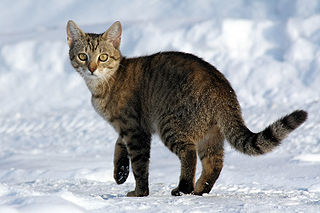

In [44]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

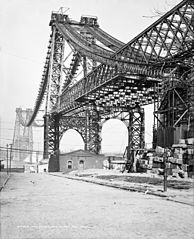

In [45]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg">From Wikimedia</a>'))

<a id="6.2"></a><a name="6.2"></a>
## 6.2. Write the TFRecord file
<a href="#top">[back to top]</a>

As before, encode the features as types compatible with `tf.train.Example`. 

This stores the raw image string feature, as well as the height, width, depth, and arbitrary `label` feature. 

The `label` feature is used when you write the file to distinguish between the cat image and the bridge image. 

For this, use `0` for the cat image, and `1` for the bridge image:

In [46]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [47]:
# This is an example using the cat image.
image_string = open(cat_in_snow, 'rb').read()

label = image_labels[cat_in_snow]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


# for line in str(image_example(image_string, label)).split('\n')[:15]:
#     print(line)
# print('...')

print(f"label: {label}, {type(label)}")
print(f"image_string: {type(image_string)}")

label: 0, <class 'int'>
image_string: <class 'bytes'>


---
Notice that all of the features are now stored in the `tf.train.Example` message. 

Next, functionalize the code above and write the example messages to a file named `images.tfrecords`:

In [48]:
for filename, labels in image_labels.items():
    print(filename, label)

/Users/gb/.keras/datasets/320px-Felis_catus-cat_on_snow.jpg 0
/Users/gb/.keras/datasets/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg 0


In [64]:
tfrecords_dir6 = "data_tfrecords6"

os.makedirs(tfrecords_dir6, exist_ok=True)  # creating TFRecords output folder
print(f"tfrecords_dir6: {tfrecords_dir6}")

example_path6 = os.path.join(tfrecords_dir6, "example6.tfrecords")
print(f"example_path6: {example_path6}")
HR()



# Write the raw image files to `images.tfrecords`.
# record_file = 'images.tfrecords'

# Iterate through the 2 image files.

with tf.io.TFRecordWriter(
    example_path6 # pathway, including filename
) as file_writer:
    for filename, label in image_labels.items():
        print(filename, label)
        
        image_string = open(filename, 'rb').read()
        # print(type(image_string))

        # Process the two images into `tf.train.Example` messages.
        tf_example = image_example(image_string, label)
        
        # Write to a `.tfrecords` file.
        print("Writing to file:", example_path6)
        HR()
        # writer.write(tf_example.SerializeToString())
        
        input_bytes = input_sanity_check(tf_example.SerializeToString())
        file_writer.write(input_bytes)    
    
        
!du -sh {example_path6}

tfrecords_dir6: data_tfrecords6
example_path6: data_tfrecords6/example6.tfrecords
----------------------------------------
/Users/gb/.keras/datasets/320px-Felis_catus-cat_on_snow.jpg 0
Writing to file: data_tfrecords6/example6.tfrecords
----------------------------------------
/Users/gb/.keras/datasets/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg 1
Writing to file: data_tfrecords6/example6.tfrecords
----------------------------------------
 36K	data_tfrecords6/example6.tfrecords


<a id="6.3"></a><a name="6.3"></a>
## 6.3. Read the TFRecord file
<a href="#top">[back to top]</a>

You now have the file `images.tfrecords` and can now iterate over the records within to read back the contents. 

Since in this example you  only reproduce the image, the only feature you will need is the raw image string. 

Extract it using the getters described above, namely `example.features.feature['image_raw'].bytes_list.value[0]`. 

You can also use the labels to determine which record is the cat and which one is the bridge:

In [50]:
raw_image_dataset = tf.data.TFRecordDataset(example_path6)

# Dict mapping feature keys to FixedLenFeature or VarLenFeature values. 
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(
      serialized = example_proto, # Scalar string Tensor, a single serialized Example. 
      features = image_feature_description # Dict mapping feature keys to FixedLenFeature or VarLenFeature values. 
  )

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

print(parsed_image_dataset)
HR()

pp.pprint(parsed_image_dataset.__dict__)

<MapDataset element_spec={'depth': TensorSpec(shape=(), dtype=tf.int64, name=None), 'height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image_raw': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
----------------------------------------
{'_graph_attr': <tensorflow.python.framework.ops.Graph object at 0x12c667640>,
 '_input_dataset': <TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 '_map_func': <tensorflow.python.data.ops.structured_function.StructuredFunctionWrapper object at 0x12c6f2550>,
 '_metadata': ,
 '_options_attr': <tensorflow.python.data.ops.options.Options object at 0x12c72a310>,
 '_preserve_cardinality': True,
 '_use_inter_op_parallelism': True,
 '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<MapDatasetOp::Dataset>>}


---
Recover the images from the TFRecord file:

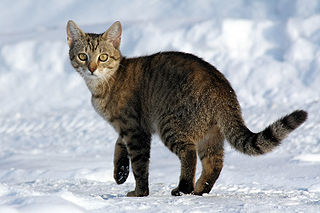

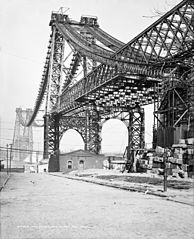

In [51]:
# Variation using IPython.display, which can take raw data in binary form
for image_features in parsed_image_dataset:
    image_raw = image_features['image_raw'].numpy()
                
    # IPython.display: Create a PNG/JPEG/GIF image object given raw data.
    display.display(display.Image(data=image_raw))

tf.Tensor(
[[194 206 218]
 [194 206 218]
 [194 206 218]
 [194 206 218]
 [195 207 219]], shape=(5, 3), dtype=uint8)


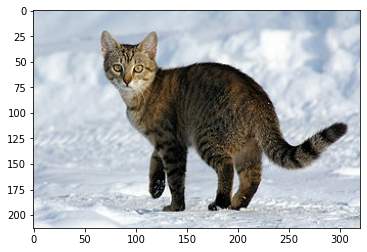

tf.Tensor(
[[238 238 238]
 [237 237 237]
 [237 237 237]
 [237 237 237]
 [237 237 237]], shape=(5, 3), dtype=uint8)


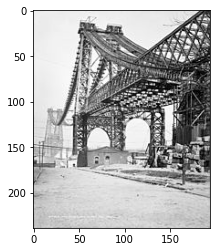

In [52]:
# Variation using matplotlib, which needs to be converted to int
for image_features in parsed_image_dataset:
    image_raw = image_features['image_raw'].numpy()
    
    # Returns a tensor with 3D or 4D shape
    converted_image = tf.io.decode_image(image_raw, channels=3)
    
    for x in converted_image:
        print(x[:5])
        break
    
    plt.imshow(converted_image)
    plt.show()

In [53]:
!du -hs ./data_tfrecords*

4.0K	./data_tfrecords1
8.0K	./data_tfrecords2
4.0K	./data_tfrecords3
1.0M	./data_tfrecords4
1.0M	./data_tfrecords5
 36K	./data_tfrecords6


In [54]:
# Clean up stored tf_record data
!rm -rf ./data_tfrecords*

---

Portions of this page are modifications based on work created and shared by Google and used according to terms described in the Creative Commons 4.0 Attribution License. 

Original material: [TFRecord and tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord#writing_a_tfrecord_file)